# Detecting Algal Blooms off of the Florida Coast

Installs, Imports, Inits

In [1]:
# !pip install geojson
#!pip install geopandas
#!pip install geehydro

In [2]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [3]:
import ee
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

In [4]:
import subprocess
import geehydro
import folium as folium
import geopandas as gpd
import gdal
import pandas as pd
import matplotlib.pyplot as plt
import geojson
import datetime
from datetime import timedelta
from shapely.geometry import MultiPolygon, Polygon, Point, mapping, shape
import random  

Import Greater Shape Around Florida - Area of Interest

In [21]:
fla = gpd.read_file('./data/fla-shape/fla.shp')
footprint = None
for i in fla['geometry']:
    footprint = i
    #print(i)

In [31]:
def to_ee_poly(shape_obj):
  x, y = shape_obj.exterior.coords.xy
  return ee.Geometry.Polygon([[x[0],y[0]], [x[1],y[1]], [x[2],y[2]], [x[3],y[3]], [x[3],y[3]]])
  
greater_area = to_ee_poly(footprint)

Import and Clean Data

Check out the dataset - map blooms.

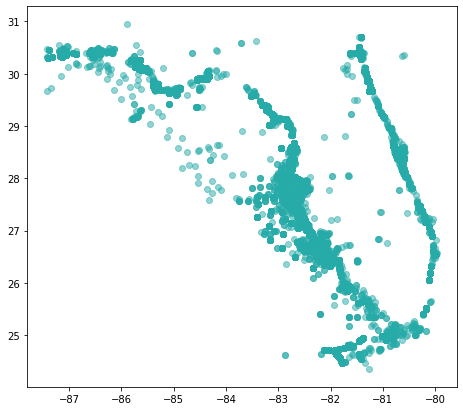

In [23]:
blooms = gpd.read_file('./data/Recent_Harmful_Algal_Bloom_HAB_Events/Recent_Harmful_Algal_Bloom_HAB_Events.shp')
blooms.plot(figsize=(8,7), alpha=.5, color='#26ABA9');

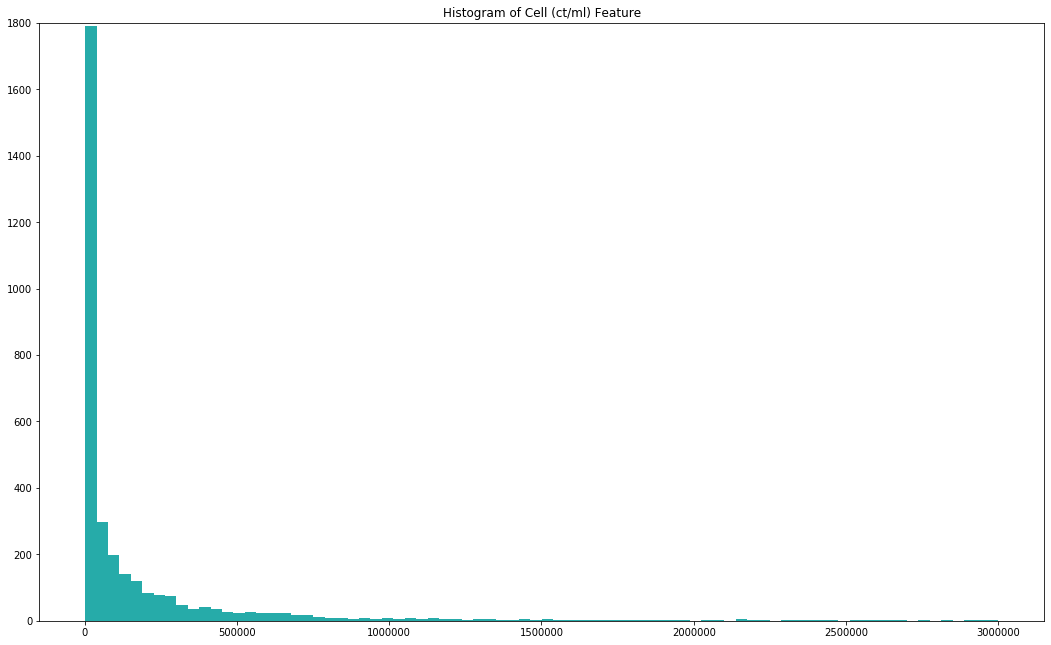

In [24]:
plt.figure(figsize=(18, 11))
plt.hist(blooms['Count_'], range=(1000,3_000_000), bins=80, color='#26ABA9')
plt.title("Histogram of Cell (ct/ml) Feature")
plt.ylim(0, 1800);

In [25]:
blooms.head(3)

,OBJECTID,LATITUDE,LONGITUDE,Count_,Name,HAB_ID,Location,SAMPLE_DAT,SAMPLE_DEP,PROOF_DATE,geometry
0,17351,27.11382,-82.46883,23000,Karenia brevis,HABW160216-017,North Jetty,2016-02-15T00:00:00.000Z,0.5,2016-04-14T00:00:00.000Z,POINT (-82.46883 27.11381)
1,17352,27.10034,-82.46089,8000,Karenia brevis,HABW160216-018,Venice Beach,2016-02-15T00:00:00.000Z,0.5,2016-04-14T00:00:00.000Z,POINT (-82.46089 27.10033)
2,17353,27.07827,-82.45286,9000,Karenia brevis,HABW160216-019,Service Club Park,2016-02-15T00:00:00.000Z,0.5,2016-04-14T00:00:00.000Z,POINT (-82.45286 27.07826)


In [26]:
blooms['SAMPLE_DAT'] = blooms['SAMPLE_DAT'].map(lambda x: pd.to_datetime(x[:10]))

# Create small polygon around each point in the data
blooms['SHAPE'] = blooms['geometry'].map(lambda x: x.buffer(.002).envelope)
# shapes = blooms.SHAPE.to_list()

# Create column converted to ee polygons
blooms['ee_polys'] = blooms['SHAPE'].map(to_ee_poly)

# Turn lat/lon into GEE point
blooms['LATITUDE'] = blooms.LATITUDE.astype(str)
blooms['LONGITUDE'] = blooms.LONGITUDE.astype(str)
blooms['LONGITUDE'] = blooms.LONGITUDE.map(lambda x: x + ', ')
blooms['ee_points'] = blooms.LONGITUDE + blooms.LATITUDE
blooms['ee_points'] = blooms.ee_points.map(lambda x: ee.Geometry.Point(float((x.split(', ')[0])), float((x.split(', ')[1]))))
blooms['LONGITUDE'] = blooms['LONGITUDE'].map(lambda x: x.strip(', '))

# create 2 gdfs, one for the positive class and one for the negative based on count feature
big_blooms = blooms.loc[blooms['Count_'] > 100_000]
big_blooms.reset_index(inplace=True, drop=True)
no_blooms = blooms.loc[blooms['Count_'] == 0].sample(n=1119, random_state=42)
no_blooms.reset_index(inplace=True, drop=True)

big_blooms['class'] = 1
no_blooms['class'] = 0
df = pd.concat([big_blooms, no_blooms])
df.reset_index(inplace=True, drop=True)
#df.set_geometry('SHAPE', inplace=True)
#df['month'] = df.SAMPLE_DAT.map(lambda x: x.month)

/Users/jenabrentano/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [27]:
df.groupby('class').count()

,OBJECTID,LATITUDE,LONGITUDE,Count_,Name,HAB_ID,Location,SAMPLE_DAT,SAMPLE_DEP,PROOF_DATE,geometry,SHAPE,ee_polys,ee_points
class,,,,,,,,,,,,,,
0,1119,1119,1119,1119,1119,1119,1119,1119,1119,1119,1119,1119,1119,1119
1,1119,1119,1119,1119,1119,1119,1119,1119,1119,1119,1119,1119,1119,1119


In [28]:
df['month'] = df.SAMPLE_DAT.map(lambda x: x.month)
df['year'] = df.SAMPLE_DAT.map(lambda x: x.year)

In [29]:
df.groupby(['year','class', 'month']).month.value_counts()

year  class  month  month
2016  0      1      1         26
             2      2         32
             3      3         49
             4      4         45
             5      5         29
             6      6         58
             7      7         40
             8      8         65
             9      9         54
             10     10        23
             11     11        32
             12     12        39
      1      1      1        156
             2      2         95
             3      3          2
             4      4         10
             9      9         55
             10     10       219
             11     11       195
             12     12       111
2017  0      1      1         48
             2      2         40
             3      3         42
             4      4         36
             5      5         46
             6      6         61
             7      7         53
             8      8         86
             9      9         50
             10  

Map Modis Ocean Color Sensor Data. Add layer for Chlor_a. This is not used in the model, but should be considered in subsequent iterations of the project.

In [32]:
image = ee.ImageCollection('NASA/OCEANDATA/MODIS-Terra/L3SMI').filterBounds(greater_area).filterDate('2016-09-15', '2016-10-15').min() #

Map = folium.Map(location=[27.9506, -82.4572], zoom_start=7)
Map.setOptions('HYBRID')

Map.addLayer(image, {'bands': ['chlor_a']}, 'Chlor_a')

remoteSensingReflectance = image.select(['Rrs_645', 'Rrs_555','Rrs_443'])
remoteSensingReflectanceVis = {'min': 0.0, 'max': 0.02}
Map.addLayer(remoteSensingReflectance, remoteSensingReflectanceVis,'Remote Sensing Reflectance')

Map.setControlVisibility(layerControl=True, fullscreenControl=True, latLngPopup=True)
Map

Make DF with Limited Dates for Modelling with One Composite Image. In the future use feature set created by samples from different images for each point.

In [33]:
df_agg = df.loc[(df.year == 2016) & ((df.month == 10) |(df.month == 11) |(df.month == 12))].copy()

first_date = str(df_agg['SAMPLE_DAT'].min())[:10]
last_date = str(df_agg['SAMPLE_DAT'].max())[:10]

df_agg.reset_index(inplace=True, drop=True)
print(f"""  The Positive Class has {df_agg[df_agg['class'] == 1].shape[0]} values. 
  The Negative Class has {df_agg[df_agg['class'] == 0].shape[0]} values. 
  The date range for this dataset is {first_date} to {last_date}.
  The shape of this data is: {df_agg.shape}""")


  The Positive Class has 525 values. 
  The Negative Class has 94 values. 
  The date range for this dataset is 2016-10-03 to 2016-12-30.
  The shape of this data is: (619, 17)


Map NDVI Image from Sentinel2 Satellite of Area of Interest Composite from narrowed down date range for feature collection.

In [34]:
image = ee.ImageCollection('COPERNICUS/S2').filterBounds(greater_area).filterDate(first_date, last_date).min() 
Map = folium.Map(location=[27.9506, -82.4572], zoom_start=6)
Map.setOptions('HYBRID')

folium.GeoJson(fla).add_to(Map)

Map.addLayer(image, {'bands': ['B4', 'B3', 'B2']}, 'image')

nir = image.select('B8')
red = image.select('B4')
ndvi = nir.subtract(red).divide(nir.add(red)).rename('NDVI')
ndviParams = {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'green']} #'palette': ['blue', 'white', 'green']
Map.addLayer(ndvi, ndviParams, 'NDVI image')

for i in range(0,1000):
  folium.GeoJson(df.SHAPE[i]).add_to(Map)

Map.setControlVisibility(layerControl=True, fullscreenControl=True, latLngPopup=True)
Map

Train a model with one composite image with points from the Sentinal Imagery from 3-month timeline with near infrared and red bands as practice using Earth Engine CART.

In [35]:
# Create Feature Collection
ee_feature_pts = []
for i in range(df_agg.ee_points.shape[0]):
  if df_agg['class'][i] == 1:
    ee_feature_pts.append(ee.Feature(
                      df_agg.ee_points[i],
                      {"class": 1}))
  else:
    ee_feature_pts.append(ee.Feature(
                      df_agg.ee_points[i],
                      {"class": 0}))  
fc_points = ee.FeatureCollection(ee_feature_pts)

aoi = greater_area
image_comp = ee.ImageCollection('COPERNICUS/S2').filterBounds(aoi).filterDate(first_date, last_date).min()

label = 'class'
bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12']

Build and evaluate a CART model

In [36]:
random.seed(42)

#Sample the input imagery to get a FeatureCollection of training data.
sample = image_comp.select(bands).sampleRegions(**{
      'collection': fc_points,
      'properties': [label],
      'scale' : 30})

#The randomColumn() method will add a column of uniform random
#numbers in a column named 'random' by default.
sample = sample.randomColumn()

split = 0.7  #Roughly 70% training, 30% testing.
training = sample.filter(ee.Filter.lt('random', split))
print(training.size().getInfo())
validation = sample.filter(ee.Filter.gte('random', split))
print(validation.size().getInfo())

440
179


In [37]:
#  sample regions throws away points that don't have imagery -  verify that data was all in the image
print(training.size().getInfo() + validation.size().getInfo())
print(fc_points.size().getInfo())

619
619


In [39]:
# Train a CART classifier with default parameters.
trained = ee.Classifier.cart().train(training, label, bands)

# Classify the image with the same bands used for training.
classified_train = image.select(bands).classify(training)
classified_val = image.select(bands).classify(validation)

cfm = trained.confusionMatrix()
cfm_array = cfm.getInfo()
acc = (cfm_array[0][0]+cfm_array[1][1]) / (cfm_array[0][0]+cfm_array[0][1]+cfm_array[1][0]+cfm_array[1][1])
print(f'Accuracy is: {acc}')
cfm_array

Accuracy is: 0.954954954954955


[[49, 20], [0, 375]]

In [40]:
validated = validation.classify(trained)
testAccuracy = validated.errorMatrix('class', 'classification')
#confusionMatrix = ee.ConfusionMatrix(validation.classify(trained))


In [42]:
print('Validation error matrix: ', testAccuracy.getInfo())

Validation error matrix:  [[14, 23], [9, 144]]


In [43]:
print('Validation overall accuracy: ', testAccuracy.accuracy().getInfo())

Validation overall accuracy:  0.85625


Map Classification!

In [44]:
image = ee.ImageCollection('COPERNICUS/S2').filterBounds(greater_area).filterDate(first_date, last_date).min() #dates defined in first model below

Map = folium.Map(location=[27.9506, -82.4572], zoom_start=6)
Map.setOptions('HYBRID')

Map.addLayer(image, {'bands': ['B4', 'B3', 'B2']}, 'image')

classified = image.classify(trained)
Map.addLayer(classified, #validated also does not throw error
             {'min': 0, 'max': 2}, # 'palette': ['red', 'green', 'blue']
             'classification')

Map.setControlVisibility(layerControl=True, fullscreenControl=True, latLngPopup=True)
Map